# Tutorial 2: Smoothing data (density estimation and local regression)

## Eric Feigelson 
## XVII Summer School in Statistics for Astronomers  June 2022


**Adapted from R scripts in Appendix B,  *Modern Statistical Methods for Astronomy With R Applications*,  Eric D. Feigelson & G. Jogesh Babu 2012  http://astrostatistics.psu.edu/MSMA**

**If code using CRAN packages does not run in the Google Co
laboratory environment, cut-and-paste it into your local R console.**


Smoothing data is a nice way to continuing learning R after our introduction.  It is often used in astronomical studies, and illustrates the variety of methodological approaches to a problem using R/CRAN software.

The formal name for smoothing is 'nonparametric density estimation'. Here one seeks an optimal continuous curve derived from low-dimensional point processes. As with regression, a response variable ('y' axis) must be chosen so that the dispersion in that variable is minimized in some fashion.  Typically, a smoothing 'bandwidth' must be chosen or calculated.  Too large a bandwidth will miss structural details (increase bias) while too small a bandwidth will add noise (increase variance).  

Thorough background on nonparametric density estimation, including many R scripts, can be found in volumes like:

*  'Local Regression and Likelihood' (C. Loader 1999)
*  'An Introduction to Nonparametric Regression' (K. Takezawa 2006)
*  ‘Semiparametric Regression with R' (J. Harezlak et al 2018).

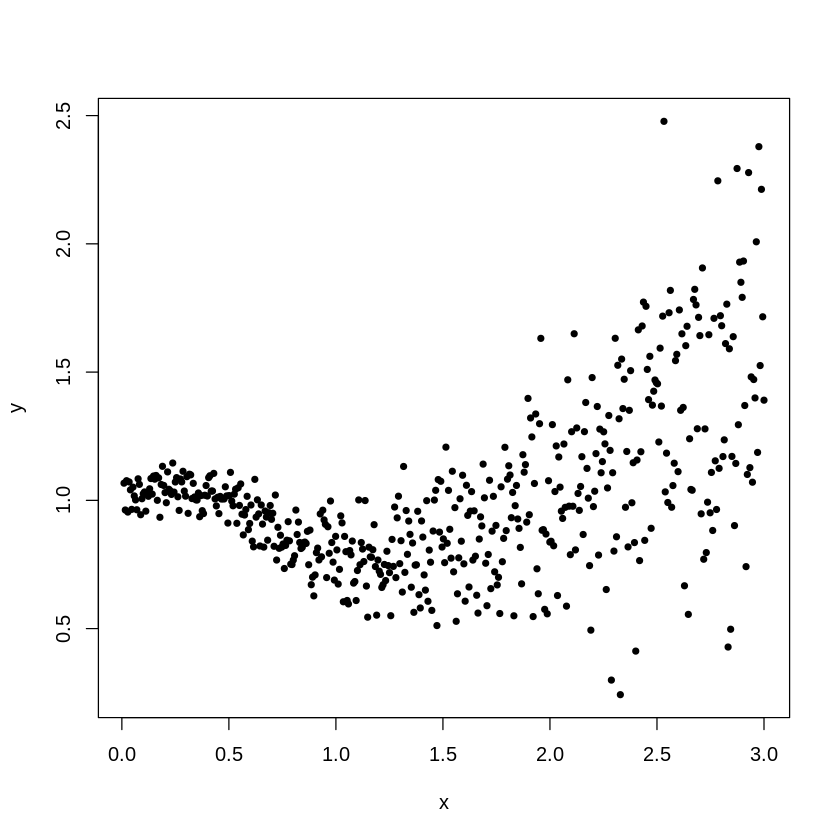

In [ ]:
# A bivariate dataset with nonlinear relationship and heteroscedasticity

set.seed(1)
x <- sample(seq(0.01, 3, length.out=500))
y <- 0.5*x + 0.3^(x^2) + rnorm(500, mean=0, sd=(0.05*(1+x^2)))
xy <- cbind(x, y)
plot(xy, pch=20)

We start with a kernel density estimation with a Gaussian kernel chosen with the direct plug-in algorithm.  Here are two graphical displays of a continuous 3D function: a color image with contours, and a perspective plot.  


[1] 0.1966203

[1] 0.04930169

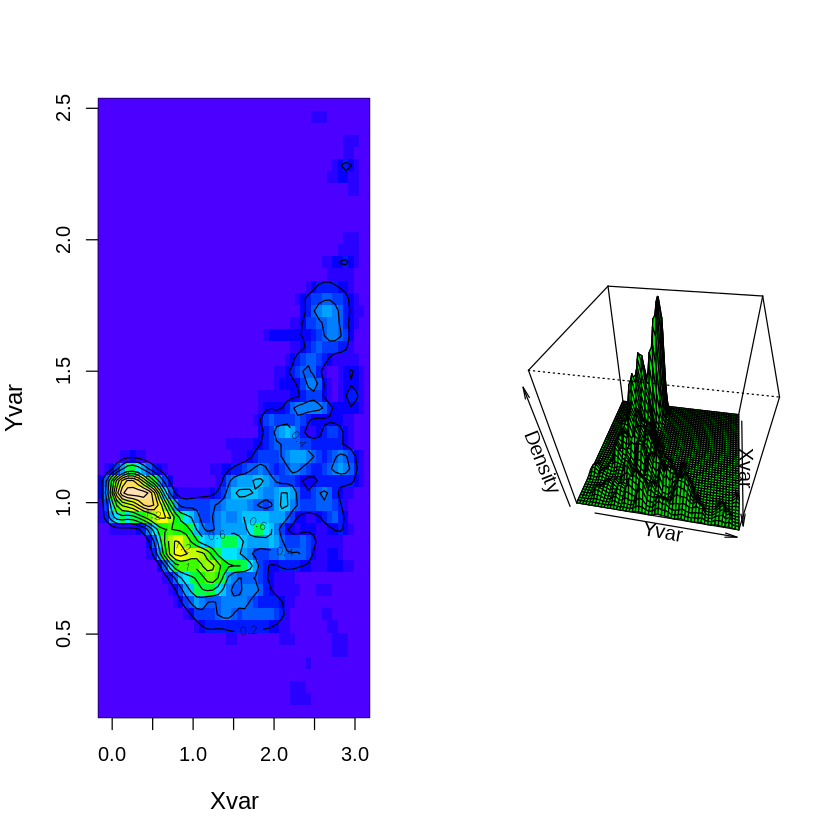

In [ ]:
# I. Kernel density estimator with two visualizations

par(mfrow=c(1,2))
library(KernSmooth)
dpik(x) ; dpik(y) 
smxy <- bkde2D(xy, bandwidth=c(0.5*dpik(x),0.5*dpik(y)))
image(smxy$x1, smxy$x2, smxy$fhat, col=topo.colors(30), xlab='Xvar', ylab='Yvar', cex.lab=1.2)
contour(smxy$x1, smxy$x2, smxy$fhat, add=T)
persp(smxy$x1,smxy$x2, smxy$fhat, theta=100, phi=40, shade=0.1, col='green1', xlab='Xvar', ylab='Yvar', zlab='Density')



> **Exercise:** Try different kernel widths: different 'scalest' parameter values within dpik.  Try 'locpoly', another smoothing functions in the KernSmooth package.

### II. Two spline fits

We start with a standard cubic smoothing spline fit.  This function is based on code in a long-established Fortran package. We then proceed with a more modern spline regression that prunes knots based on the Bayesian Information Criterion likelihood measure, and computes spline functions for different quantiles of dispersion in the response variable.  This combination of local regression and quantile regression is particularly useful in astronomy where the errors (scatter) is often non-Gaussian, heteroscedastic (depends on the covariates) and asymmetrical.  


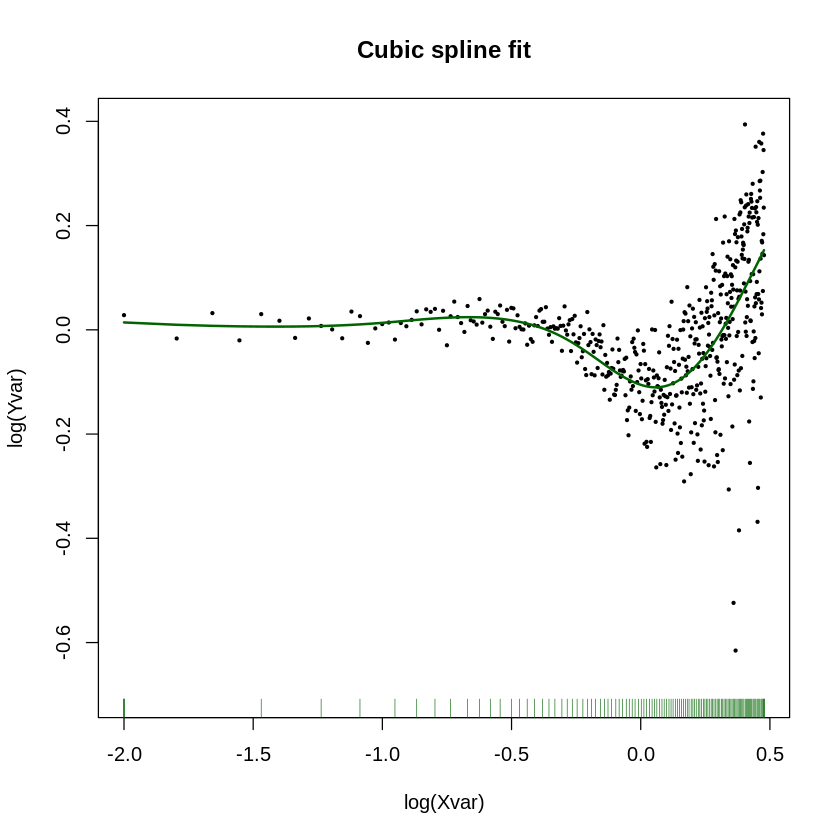

In [ ]:
# Classic spline fit 

cubsplxy <- smooth.spline(log10(xy))
plot(log10(xy), pch=20, cex=0.5, ylim=c(-0.7, 0.4), xlab='log(Xvar)', 
     ylab='log(Yvar)', main='Cubic spline fit')  # Plot points
lines(cubsplxy, lwd=2, col='darkgreen')  # Plot the spline fit
knotx <- cubsplxy$fit$knot*cubsplxy$fit$range + cubsplxy$fit$min   # Find and plot the spline knots
rug(knotx,col='darkgreen')


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘MatrixModels’, ‘SparseM’, ‘quantreg’




qbsks2():
 Performing general knot selection ...

 Deleting unnecessary knots ...
qbsks2():
 Performing general knot selection ...

 Deleting unnecessary knots ...
qbsks2():
 Performing general knot selection ...

 Deleting unnecessary knots ...
qbsks2():
 Performing general knot selection ...

 Deleting unnecessary knots ...


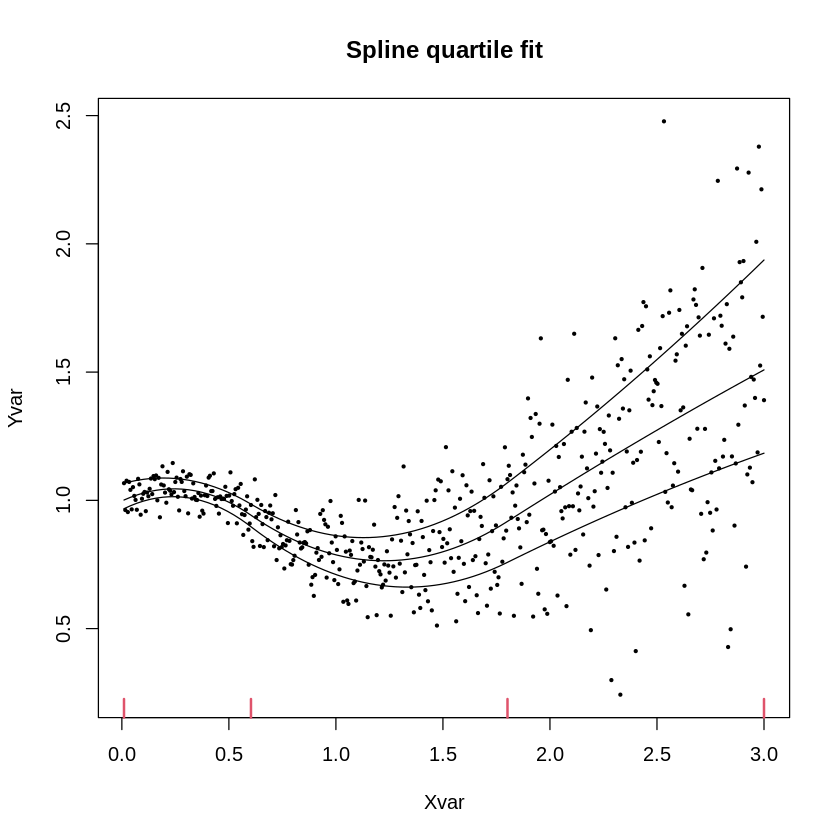

In [ ]:
# Constrained B-Splines Nonparametric Regression Quantiles
# Bartels, R. and Conn A. (1980) Linearly Constrained Discrete L_1 Problems, ACM Transaction on Mathematical Software 6, 594Ã¢â‚¬â€œ608.
# Ng, P. (1996) An Algorithm for Quantile Smoothing Splines, Computational Statistics & Data Analysis 22, 99Ã¢â‚¬â€œ118.
# He, X. and Ng, P. (1999) COBS: Qualitatively Constrained Smoothing via Linear Programming; Computational Statistics 14, 315Ã¢â‚¬â€œ337.
# Ng, P. and Maechler, M. (2007) A Fast and Efficient Implementation of Qualitatively Constrained Quantile Smoothing Splines, Statistical Modelling 7(4), 315-328.

install.packages('cobs', repos="https://cloud.r-project.org", dependencies=TRUE)
library(cobs) 
plot(xy, pch=20, cex=0.5, xlab='Xvar', ylab='Yvar', 
	main='Spline quartile fit')  # Plot points
lines(predict(cobs(x,y, ic='BIC', tau=0.25)))
lines(predict(cobs(x,y, ic='BIC', tau=0.50)))
lines(predict(cobs(x,y, ic='BIC', tau=0.75)))
rug(cobs(x,y, ic='BIC', tau=0.50)$knots, lwd=2, col=2)

> **Exercise:** Try different parameter options within COBS such as nknots, degree, lambda, and ic. See help(cobs).  

### III. Four well-established bivariate semi-parametric local regression estimators

1. LOESS, 'LOcal regrESSion' in base-R, widely used (0.3M Google hits). Local polynomial regression with robust treatment of outliers.  Description in [Wikipedia](https://en.wikipedia.org/wiki/Local_regression).   Presented in the book W. S. Cleveland, `Visualizing Data', Hobart Press 1993

2. Nonparametric regression with bootstrap errors in CRAN package 'np'. See Hayfield, T. & Racine, J. S. Nonparametric Econometrics: The np package, [J. Statist. Software, 27(5), 2008](http://www.jstatsoft.org/v27/i05/).

3. Locfit in CRAN package 'locfit', widely used (0.1M Google hits, >200 downloads/day).  Local kernel regression methods including heteroscedastic weighting (unequal error bars), censoring (upper limits), and outliers.  Presented in the book Loader, C. (1999) _Local Regression and Likelihood_ Springer, New York.

4. Gaussian Process regression, commonly known outside astronomy as `kriging` from its original development for geostatistics. Response variable errors and independent variable covariance are assumed to be normal.  Maximum likelihood & Bayesian estimation.  Description in book  Rasmussen & Williams, Gaussian Processes for Machine Learning, 2006.   Other Gaussian processes regression codes are given in CRAN packages
'mlegp' (Maximum Likelihood Estimates of Gaussian Processes) and 'gptk'
(Gaussian Processes tool-kit). See also the tutorial [here](http://www.r-bloggers.com/gaussian-process-regression-with-r/). 

Finally, we plot all of these nonparametric regressions on the same plot.  We find that, in this case, they are quite compatible with each other.
  


Call:
loess(formula = sorty ~ sortx, data = data.frame(x = x, y = y), 
    span = 0.25)

Number of Observations: 500 
Equivalent Number of Parameters: 11.92 
Residual Standard Error: 0.2459 
Trace of smoother matrix: 13.17  (exact)

Control settings:
  span     :  0.25 
  degree   :  2 
  family   :  gaussian
  surface  :  interpolate	  cell = 0.2
  normalize:  TRUE
 parametric:  FALSE
drop.square:  FALSE 

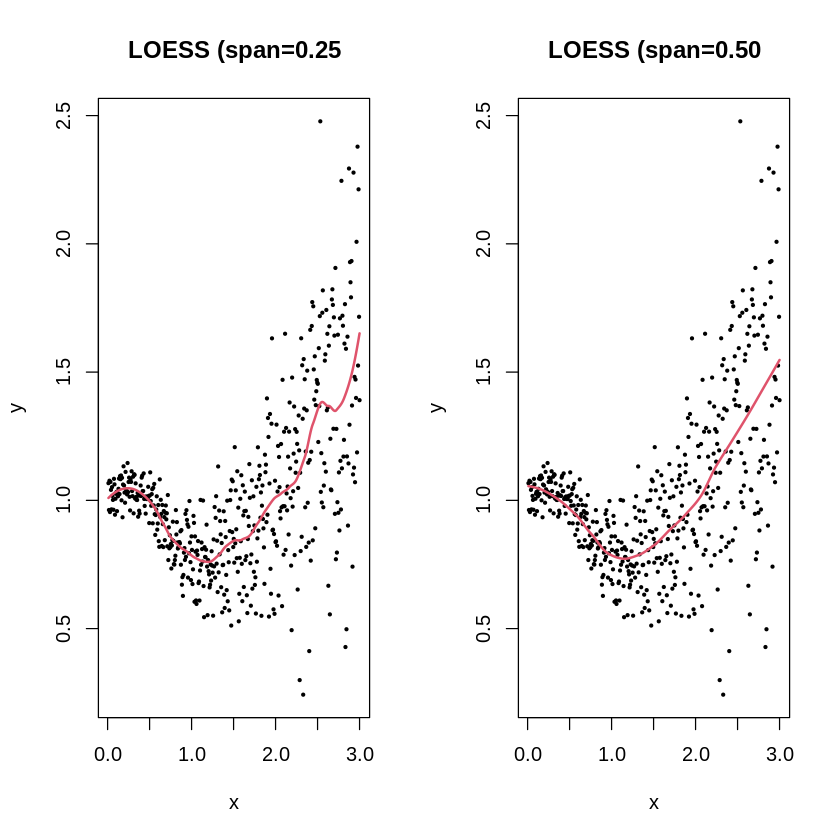

In [ ]:
# LOESS,  W. S. Cleveland, `Visualizing Data', Hobart Press 1993

par(mfrow=c(1,2))
sortx <- x[order(x)] ; sorty <- y[order(x)]
local_fit <- loess(sorty ~ sortx, span=0.25, data.frame(x=x,y=y))	
summary(local_fit)
plot(x,y,pch=20, cex=0.5, main='LOESS (span=0.25')
lines(sortx, predict(local_fit), lwd=2, col=2)

local_fit <- loess(sorty ~ sortx, span=0.50, data.frame(x=x,y=y))	
plot(x,y,pch=20, cex=0.5, main='LOESS (span=0.50')
lines(sortx, predict(local_fit), lwd=2, col=2)

# Save evenly-spaced LOESS fit to a file 

x_seq <- seq(0.0, 3.0, by=0.03) 
loc_dat <- predict(local_fit, newdata=x_seq)
write(rbind(x_seq,loc_dat), sep=' ', ncol=2, file='localfit.txt')

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘Rcpp’, ‘cubature’, ‘quadprog’


Nonparametric Kernel Methods for Mixed Datatypes (version 0.60-11)
[vignette("np_faq",package="np") provides answers to frequently asked questions]
[vignette("np",package="np") an overview]
[vignette("entropy_np",package="np") an overview of entropy-based methods]



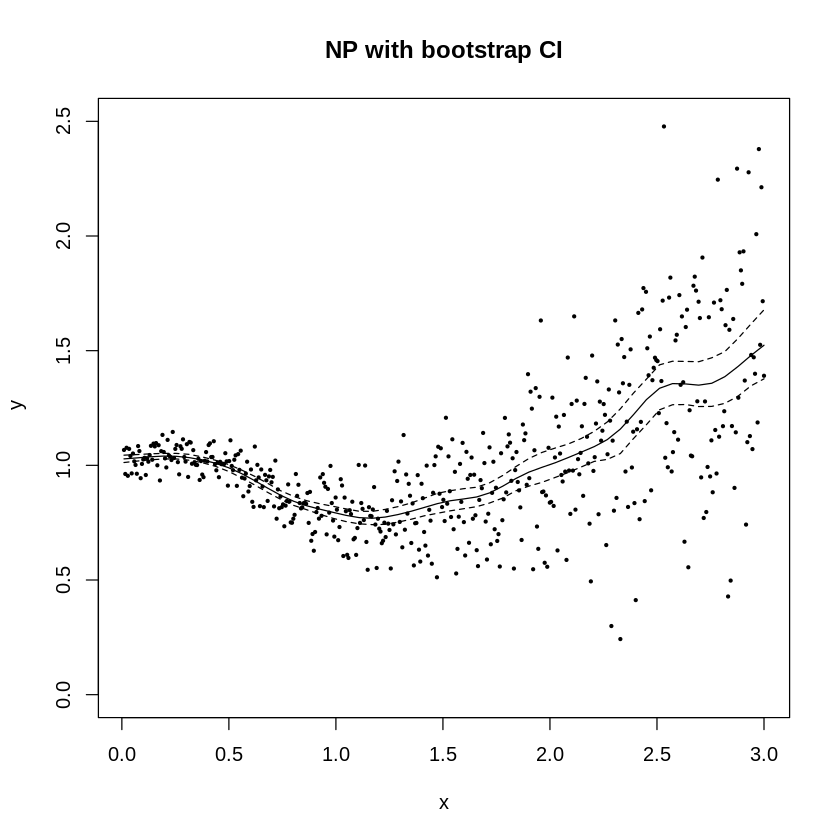

In [ ]:
# Nonparametric regression with bootstrap errors
# Hayfield, T. & Racine, J. S. Nonparametric Econometrics: The np package, 
# J. Statist. Software, 27(5), 2008   http://www.jstatsoft.org/v27/i05/

install.packages("np", repos="https://cloud.r-project.org", dependencies=TRUE) 
library(np)
bw.NW <- npregbw(x, y, regtype='lc', bwtype='fixed')
# help(npregbw)
# help(npplot)
# str(bw.NW)
# bw.NW$bw <- 0.5 * bw.NW$bw
# cat('New bandwidth for np local regression = ', bw.NW$bw)
npplot(bws=bw.NW, ylim=c(0.0,2.5), plot.errors.method="bootstrap", 
    plot.errors.bar='I', plot.errors.type='quantiles', main='NP with bootstrap CI') 
points(x, y, pch=20, cex=0.5)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

locfit 1.5-9.5 	 2022-03-01



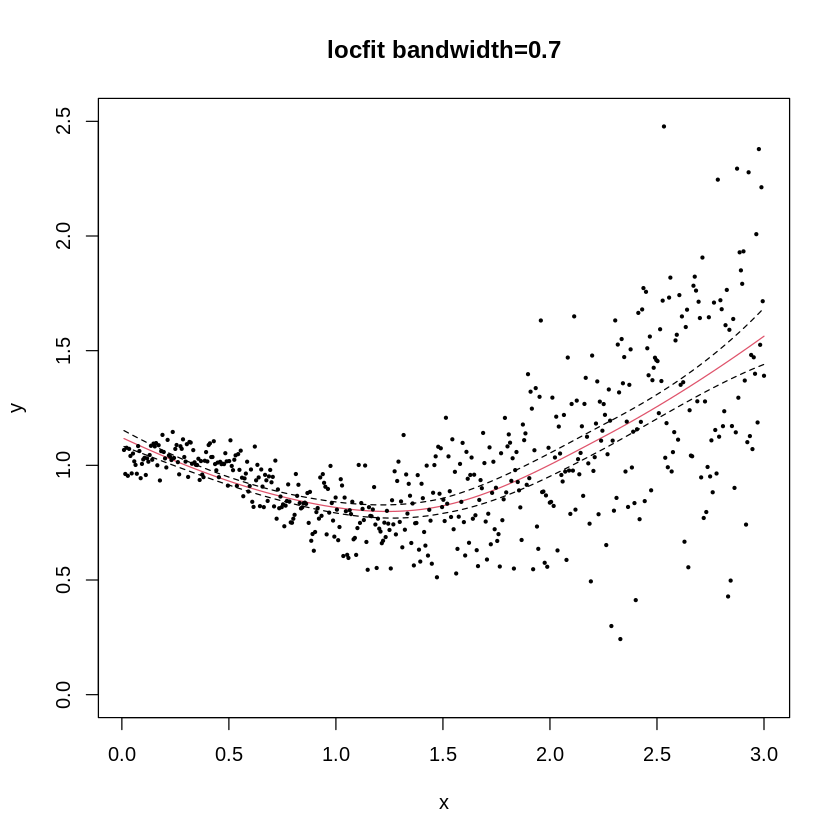

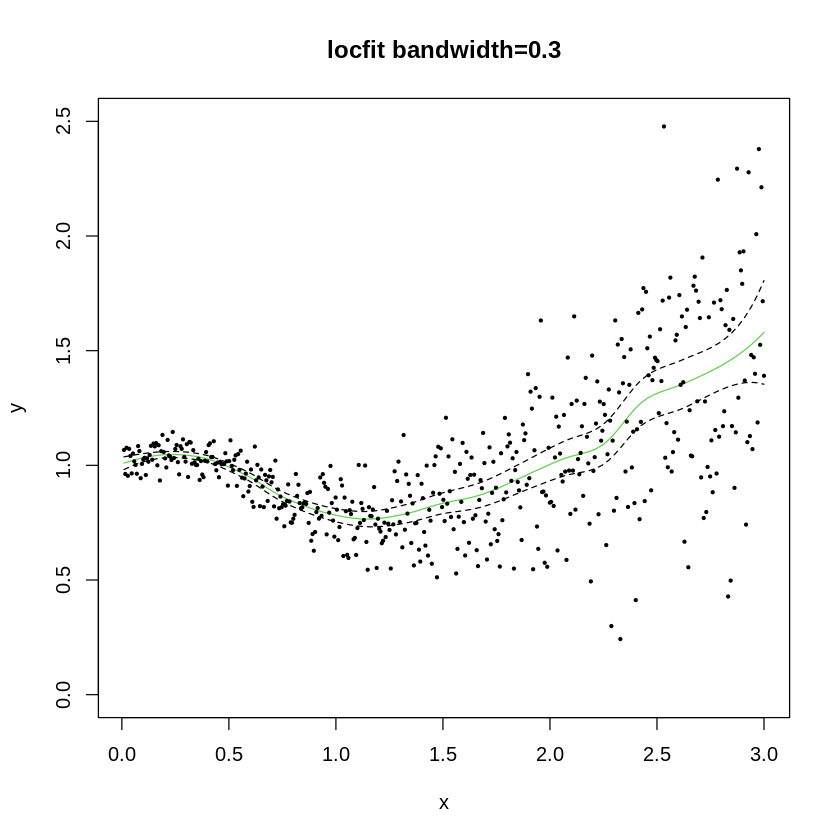

In [ ]:
# Locfit: local kernel regression methods including heteroscedastic weighting
# (unequal error bars), censoring (upper limits), and outliers.
# Loader, C. (1999). Local Regression and Likelihood. Springer, New York.
# >200 downloads/day

install.packages('locfit')  ;  library(locfit)
locfit_model <- locfit(y~lp(x, nn=0.7))
plot(locfit_model, band='local', ylim=c(0,2.5), col=2, main='locfit bandwidth=0.7')  ;  points(xy, pch=20, cex=0.5)
locfit_model <- locfit(y~lp(x, nn=0.3))
plot(locfit_model, band='local', ylim=c(0,2.5), col=3, main='locfit bandwidth=0.3')  ;  points(xy, pch=20, cex=0.5)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



Gaussian Processes object of class "gausspr" 
Problem type: regression 

Polynomial kernel function. 
 Hyperparameters : degree =  5  scale =  1  offset =  1 

Number of training instances learned : 500 
Train error : 0.568905154 
Cross validation error : 0.06271113 

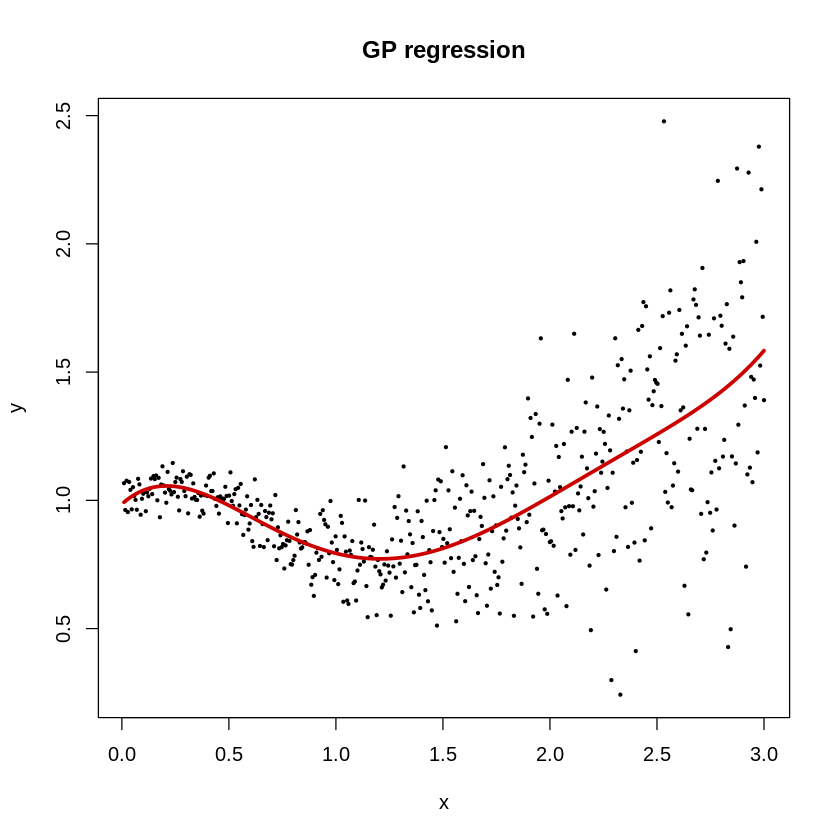

In [ ]:
# Gaussian process regression (more commonly known as `kriging')
# Response variable errors and independent variable covariance assumed to be normal
# Maximum likelihood & Bayesian estimation
# Rasmussen & Williams, Gaussian Processes for Machine Learning, 2006

install.packages('kernlab') ; library(kernlab)
gpreg <- gausspr(x, y, variance.model=T, cross=10, kerne='polydot', kpar=list(5))
gpreg
xtest <- seq(from=min(x), to=max(x), length.out=200)
plot(x, y, pch=20, cex=0.5, main='GP regression')
lines(xtest, predict(gpreg, xtest), col='red3', lwd=3)

qbsks2():
 Performing general knot selection ...

 Deleting unnecessary knots ...
qbsks2():
 Performing general knot selection ...

 Deleting unnecessary knots ...
qbsks2():
 Performing general knot selection ...

 Deleting unnecessary knots ...


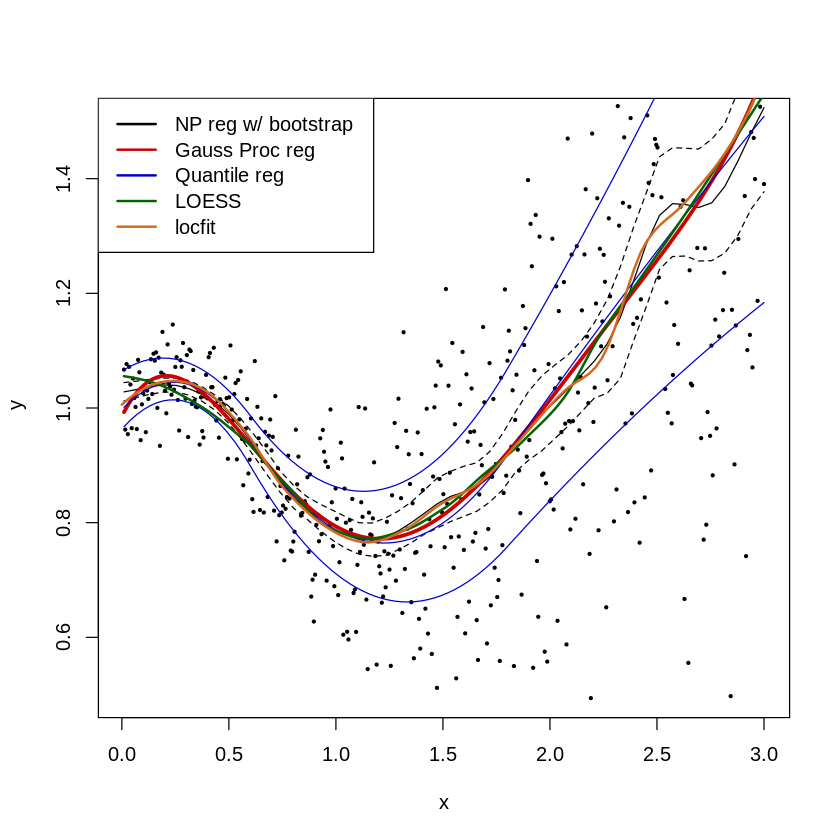

In [ ]:
# Plot several smooth density estimators on a single graph

npplot(bws=bw.NW, ylim=c(0.5,1.5), plot.errors.method="bootstrap",
plot.errors.bar='I', plot.errors.type='quantiles') 	# Nonparametric regression w/ bootstrap errors
points(x, y, pch=20, cex=0.5)
lines(xtest, predict(gpreg, xtest), col='red3', lwd=3)  #  Gaussian Processes regression
lines(predict(cobs(x,y, ic='BIC', tau=0.25)), col='blue3')
lines(predict(cobs(x,y, ic='BIC', tau=0.50)), col='blue3')
lines(predict(cobs(x,y, ic='BIC', tau=0.75)), col='blue3')
lines(sortx, predict(local_fit), lwd=2, col='darkgreen') # LOESS
locfit_values <- predict(locfit_model, seq(0,3,length.out=100))
lines(seq(0,3,length.out=100), locfit_values, lwd=2, col="chocolate")  # locfit
legend('topleft', lty=1, lwd=2, c("NP reg w/ bootstrap",'Gauss Proc reg', 'Quantile reg', 'LOESS', 'locfit'), col=c('black', 'red3', 'blue3', 'darkgreen', 'chocolate'))


> **Exercise:**  Choose one of these methods, read the help file, and play around with the input parameters.  Note that sometimes multiple functions are involved, such as _loess.control_ associated with _loess_, and _locfit.raw_ and _lp_ associated with _locfit_.

> **Exercise:** Perhaps the most capable of these packages, with strong foundations in likelihood theory, is Clive Loader's _locfit_ written in the early years of R.   It incorporates complexities such as survival analysis for nondetections, robust regression for non-Gaussian scatter, and heteroscedasticity for measurement error weighting.  To exercise _locfit_ well, it is necessary to get a hold of the 1999 Springer book by Loader, which unfortunately is not available in electronic form.

We can make several observations from this tutorial:

1.   Modern statistics often provides several different approaches to the same scientific goal. Here the goal is: Find a continuous curve that best represents the 500 observed points.  All of the methods give 'correct' mathematical solutions within their approach ... it is not obvious which is 'better' than another.  

2.   Methods often have some free parameter.  Here it is the smoothing 'bandwidth', 'span', 'kernel' or similar quantity.  In some cases, the scientist has to guess what value to use. In other cases, the statistician provides guidance. In kernel density estimation, the bandwidth is often set to give the Minimum Integrated Standard Error (sum of bias^2 and variance) and is estimated using cross-validation techniques. This was too complicated for our tutorial here, but is discussed in textbooks like [`All of Nonparametric Statistics'](https://link.springer.com/book/10.1007/0-387-30623-4) by Larry Wasserman (2006, Springer), blog entry [here](https://www.r-bloggers.com/2014/10/cross-validation-for-kernel-density-estimation/), and CRAN functions like [*fkden*](https://cran.r-project.org/web/packages/evmix/evmix.pdf) in package *evmix*.

3. The final plot here shows that the different density estimators are quite similar to each other. It is comforting that, for this case, it does not matter much which is chosen for scientific use.  Note however that they differ in the confidence bands.  This is not uncommon, and suggests that caution should be used in evaluating the accuracy of these smoothed estimators.


